Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
5000/tcp:             3129  3131  3132  3133  3134
MLflow Tracking UI: NgrokTunnel: "https://cbd05405d6a4.ngrok-free.app" -> "http://localhost:5000"


2025/09/01 16:16:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/01 16:16:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Hotel_Booking_Cancellation_Predictor_LR' already exists. Creating a new version of this model...
Created version '4' of model 'Hotel_Booking_Cancellation_Predictor_LR'.


Accuracy: 0.7811374486975459
ROC AUC: 0.8640705052239135

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82     15033
           1       0.69      0.73      0.71      8845

    accuracy                           0.78     23878
   macro avg       0.77      0.77      0.77     23878
weighted avg       0.78      0.78      0.78     23878


Confusion Matrix:
 [[12192  2841]
 [ 2385  6460]]

MLflow run completed! Run ID: b620112145db446da966fbad51c42051


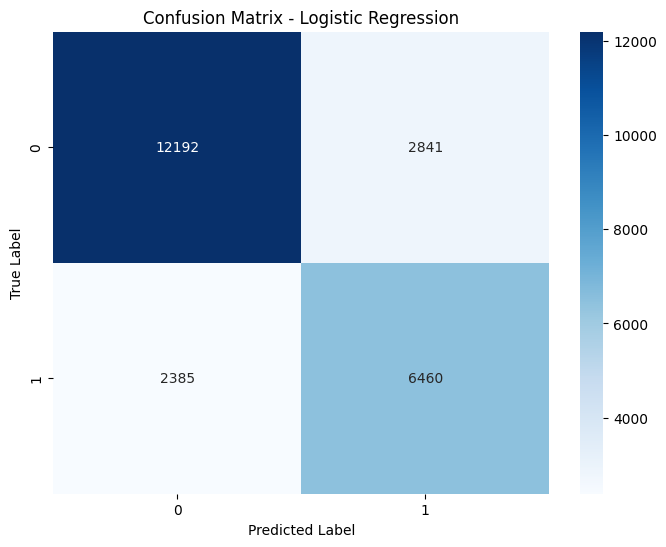

In [ ]:
# =========================
# Install & Import Packages
# =========================
!pip install mlflow pyngrok

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from pyngrok import ngrok
import mlflow
import mlflow.sklearn
import os

warnings.filterwarnings('ignore')

# =========================
# Mount Google Drive (persistent storage for MLflow)
# =========================
from google.colab import drive
drive.mount('/content/drive')

# Create MLflow tracking folder in Drive
mlflow_dir = "/content/drive/MyDrive/mlruns"
os.makedirs(mlflow_dir, exist_ok=True)

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"file:{mlflow_dir}")
mlflow.set_experiment("Hotel_Booking_Experiment_LogReg")

# =========================
# Start MLflow UI with ngrok (fresh tunnel every time)
# =========================
ngrok.set_auth_token("323kbTXURVBUj6zI9niWJPN1TuP_2tZXgYxysDeXJGkCv33ND")  # replace with your own token

# Kill old ngrok tunnels
ngrok.kill()

# Kill any MLflow UI running on port 5000
!fuser -k 5000/tcp || echo "No process on 5000"

# Start MLflow UI in background
get_ipython().system_raw(f"mlflow ui --backend-store-uri file:{mlflow_dir} --port 5000 &")

# Start new tunnel (fresh each time)
public_url = ngrok.connect(5000, "http")
print("MLflow Tracking UI:", public_url)

# =========================
# Load Dataset
# =========================
df = pd.read_csv("hotel_bookings.csv")

# Preprocessing
df_clean = df.copy()
month_map = {m: i for i, m in enumerate(
    ['January','February','March','April','May','June',
     'July','August','September','October','November','December'], 1)}
df_clean['arrival_date_month'] = df_clean['arrival_date_month'].map(month_map)
df_clean.drop('reservation_status_date', axis=1, inplace=True)
df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
df_clean['total_guests'] = df_clean['adults'] + df_clean['children'] + df_clean['babies']
df_clean['is_family'] = ((df_clean['children'] > 0) | (df_clean['babies'] > 0)).astype(int)

# Fill missing
df_clean.fillna(0, inplace=True)

# Encode categorical
encode_cols = ['hotel','meal','country','market_segment','distribution_channel',
               'reserved_room_type','assigned_room_type','deposit_type','customer_type']
for col in encode_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

df_clean.drop(['reservation_status'], axis=1, inplace=True, errors="ignore")

# Split
X = df_clean.drop('is_canceled', axis=1)
y = df_clean['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# Train Logistic Regression with MLflow
# =========================
with mlflow.start_run(run_name="Logistic_Regression_Final"):
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = lr_model.predict(X_test_scaled)
    y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report_dic = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log params & metrics
    mlflow.log_params({"model_type": "LogReg", "max_iter": 1000, "class_weight": "balanced"})
    mlflow.log_metrics({
        "accuracy": acc,
        "roc_auc": roc_auc,
        "precision_0": report_dic['0']['precision'],
        "recall_0": report_dic['0']['recall'],
        "f1_score_0": report_dic['0']['f1-score'],
        "precision_1": report_dic['1']['precision'],
        "recall_1": report_dic['1']['recall'],
        "f1_score_1": report_dic['1']['f1-score']
    })

    # Log model
    mlflow.sklearn.log_model(lr_model, "log_reg_model",
                             registered_model_name="Hotel_Booking_Cancellation_Predictor_LR")

    # Confusion matrix plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Feature importance
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": lr_model.coef_[0]
    }).sort_values("importance", ascending=False)
    feature_importance.to_csv("feature_importance.csv", index=False)
    mlflow.log_artifact("feature_importance.csv")

    print("Accuracy:", acc)
    print("ROC AUC:", roc_auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", cm)
    print(f"\nMLflow run completed! Run ID: {mlflow.active_run().info.run_id}")


In [ ]:
!pkill ngrok